In [1]:
datos=spark.read.csv("customer_churn.csv",header=True,
                     inferSchema=True)

In [4]:
datos.show(2,vertical=True),datos.printSchema()

-RECORD 0-------------------------------
 Names           | Cameron Williams     
 Age             | 42.0                 
 Total_Purchase  | 11066.8              
 Account_Manager | 0                    
 Years           | 7.22                 
 Num_Sites       | 8.0                  
 Onboard_date    | 2013-08-30 07:00:40  
 Location        | 10265 Elizabeth M... 
 Company         | Harvey LLC           
 Churn           | 1                    
-RECORD 1-------------------------------
 Names           | Kevin Mueller        
 Age             | 41.0                 
 Total_Purchase  | 11916.22             
 Account_Manager | 0                    
 Years           | 6.5                  
 Num_Sites       | 11.0                 
 Onboard_date    | 2013-08-13 00:38:46  
 Location        | 6157 Frank Garden... 
 Company         | Wilson PLC           
 Churn           | 1                    
only showing top 2 rows

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = tr

(None, None)

In [6]:
datos.describe().show(vertical=True)

-RECORD 0-------------------------------
 summary         | count                
 Names           | 900                  
 Age             | 900                  
 Total_Purchase  | 900                  
 Account_Manager | 900                  
 Years           | 900                  
 Num_Sites       | 900                  
 Location        | 900                  
 Company         | 900                  
 Churn           | 900                  
-RECORD 1-------------------------------
 summary         | mean                 
 Names           | null                 
 Age             | 41.81666666666667    
 Total_Purchase  | 10062.82403333334    
 Account_Manager | 0.4811111111111111   
 Years           | 5.27315555555555     
 Num_Sites       | 8.587777777777777    
 Location        | null                 
 Company         | null                 
 Churn           | 0.16666666666666666  
-RECORD 2-------------------------------
 summary         | stddev               
 Names          

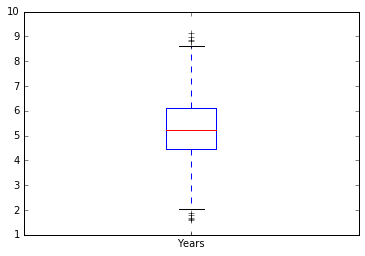

In [10]:
datos.select("Years").toPandas().plot.box()

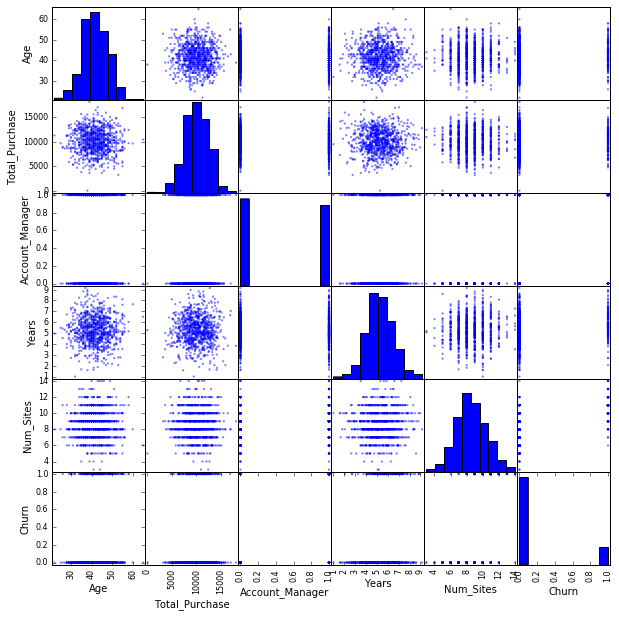

In [12]:
from pandas.plotting import scatter_matrix
g=scatter_matrix(datos.toPandas(),figsize=(10,10))

In [13]:
datos.columns

['Names',
 'Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites',
 'Onboard_date',
 'Location',
 'Company',
 'Churn']

In [15]:
datos.crosstab('Account_Manager','Churn').show()

+---------------------+---+---+
|Account_Manager_Churn|  0|  1|
+---------------------+---+---+
|                    1|349| 84|
|                    0|401| 66|
+---------------------+---+---+



In [17]:
datos.groupBy("Company").count().orderBy("count",ascending=False).count()

873

In [18]:
from pyspark.ml.feature import VectorAssembler

In [19]:
constructor=VectorAssembler(inputCols=['Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites'],outputCol="features")

In [20]:
datosF=constructor.transform(datos)

In [21]:
datosF.show(1,vertical=True)

-RECORD 0-------------------------------
 Names           | Cameron Williams     
 Age             | 42.0                 
 Total_Purchase  | 11066.8              
 Account_Manager | 0                    
 Years           | 7.22                 
 Num_Sites       | 8.0                  
 Onboard_date    | 2013-08-30 07:00:40  
 Location        | 10265 Elizabeth M... 
 Company         | Harvey LLC           
 Churn           | 1                    
 features        | [42.0,11066.8,0.0... 
only showing top 1 row



In [25]:
entrena,evalua=datosF.randomSplit([0.8,0.2])

In [26]:
from pyspark.ml.classification import LogisticRegression

In [27]:
lr=LogisticRegression(labelCol="Churn")

In [28]:
modelo=lr.fit(entrena)

In [29]:
modelo.summary.areaUnderROC

0.9135142543859647

In [30]:
from pyspark.ml.evaluation import (BinaryClassificationEvaluator,
                                   MulticlassClassificationEvaluator)

In [33]:
prediccion=modelo.transform(evalua)

In [34]:
evaluadorB=BinaryClassificationEvaluator(labelCol="Churn")

In [35]:
evaluadorB.evaluate(prediccion)#AUC

0.8892018779342722

In [36]:
evaluadorM=MulticlassClassificationEvaluator(labelCol="Churn",
                                             metricName="accuracy")

In [37]:
evaluadorM.evaluate(prediccion)

0.8837209302325582

In [38]:
modeloOK=lr.fit(datosF)

In [39]:
modeloOK.save("modeloLR")